# Clasificación 6 clases

## Librerias

In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, roc_curve, auc
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

## Generación de Datos

##### Grafico de la distribución de las clases

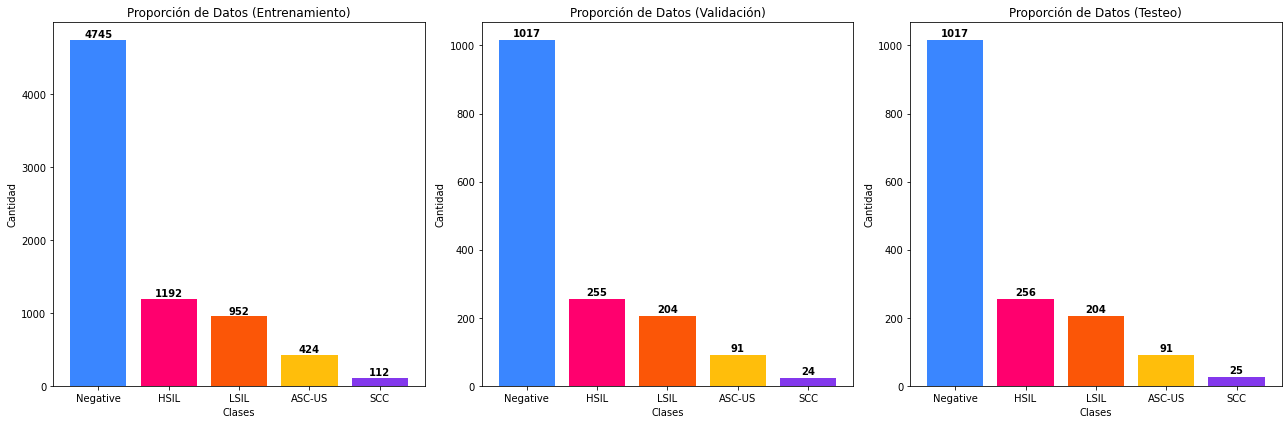

In [4]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Función para contar imágenes en cada clase dentro de la carpeta base
def count_images_in_folders(base_folder):
    class_counts = defaultdict(int)
    for class_name in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] += len(os.listdir(class_path))
    return dict(class_counts)

# Función para graficar las proporciones de las clases
def plot_class_proportion_subplot(ax, class_counts, title, order=None):
    if order:
        ordered_class_counts = {class_name: class_counts[class_name] for class_name in order if class_name in class_counts}
    else:
        ordered_class_counts = class_counts
    
    ax.bar(ordered_class_counts.keys(), ordered_class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC', '#06D6A0'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad sobre las barras
    for i, (class_name, count) in enumerate(ordered_class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento y prueba
train_dir = 'crops_6classes/train/'
val_dir = 'crops_6classes/val'
test_dir = 'crops_6classes/test'

# Contar las imágenes en cada conjunto
train_class_counts = count_images_in_folders(train_dir)
val_class_counts = count_images_in_folders(val_dir)
test_class_counts = count_images_in_folders(test_dir)

# Orden deseado de las clases
class_order = ['Negative', 'HSIL', 'LSIL', 'AUS-US', 'ASC-US', 'SCC']

# Crear gráficos para los conjuntos de entrenamiento y prueba
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Gráficos
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)', order=class_order)
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)', order=class_order)
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Testeo)', order=class_order)

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

#### Generadores

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de aumentación para entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generador de imágenes para entrenamiento en modo multiclase
train_generator = train_datagen.flow_from_directory(
    'crops_6classes/train',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', 
    shuffle=True
)

# Generador de imágenes para validación en modo multiclase
val_generator = val_test_datagen.flow_from_directory(
    'crops_6classes/val',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generador de imágenes para prueba en modo multiclase
test_generator = val_test_datagen.flow_from_directory(
    'crops_6classes/test', 
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 8072 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1732 images belonging to 6 classes.


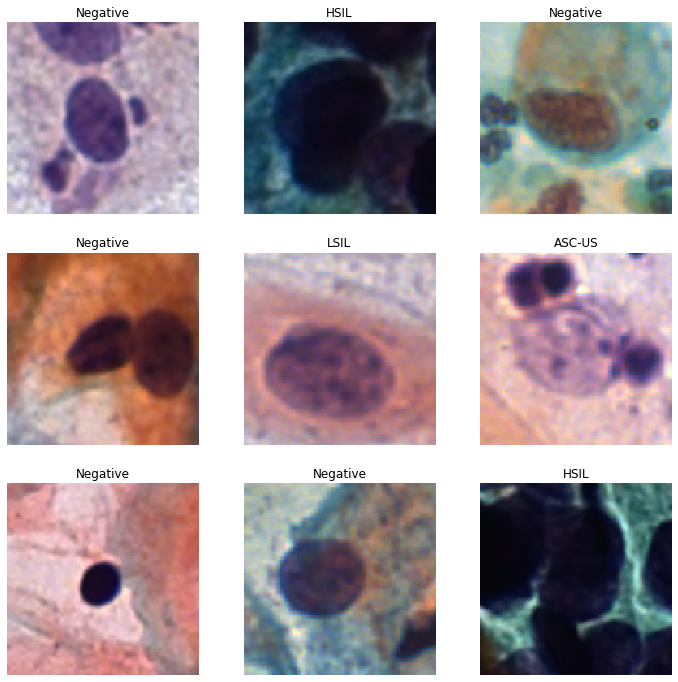

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes y etiquetas
images, labels = next(train_generator)

# Obtener los nombres de las clases
class_labels = list(train_generator.class_indices.keys())

# Visualizar las primeras 9 imágenes del batch
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis("off")
plt.show()


## Modelos

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = train_generator.num_classes

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 1018s 4s/step - accuracy: 0.4797 - auc: 0.8054 - f1_score: 0.8054 - loss: 1.5134 - precision: 0.7790 - recall: 0.1970 - val_accuracy: 0.7145 - val_auc: 0.9419 - val_f1_score: 0.9419 - val_loss: 0.7664 - val_precision: 0.7771 - val_recall: 0.6549 - learning_rate: 1.0000e-04
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 661s 3s/step - accuracy: 0.7320 - auc: 0.9431 - f1_score: 0.9431 - loss: 0.7218 - precision: 0.8112 - recall: 0.6322 - val_accuracy: 0.7578 - val_auc: 0.9529 - val_f1_score: 0.9529 - val_loss: 0.6889 - val_precision: 0.7991 - val_recall: 0.7012 - learning_rate: 1.0000e-04
Epoch 3/30
 20/253 ━━━━━━━━━━━━━━━━━━━━ 10:31 3s/step - accuracy: 0.8429 - auc: 0.9790 - f1_score: 0.9790 - loss: 0.3283 - precision: 0.9101 - recall: 0.7866

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
print(tf.__version__)